In [1]:
%matplotlib notebook
import tensorflow as tf

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils

In [2]:
tf.__version__

'2.3.1'

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

Make a dataset that has a long-term pattern.

We will generate noise from a standard normal as our dataset. So, there is no temporal structure in the data per se as each observation is i.i.d., i.e., not correlated to the surrounding data points.

This will rather be a XOR classification problem. And we will look at 3 consecutive data points (just as candles in finance) and track their sign.

In [4]:
cases: tuple = ('short-distance-10', 'long-distance-10', 'long-distance-20', 'long-distance-30')

results: dict = {case: {} for case in cases}

In [5]:
T: int = 10
D: int = 1

In [6]:
np.random.seed(0)
arr = np.random.randn(T)
arr

array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ])

<IPython.core.display.Javascript object>


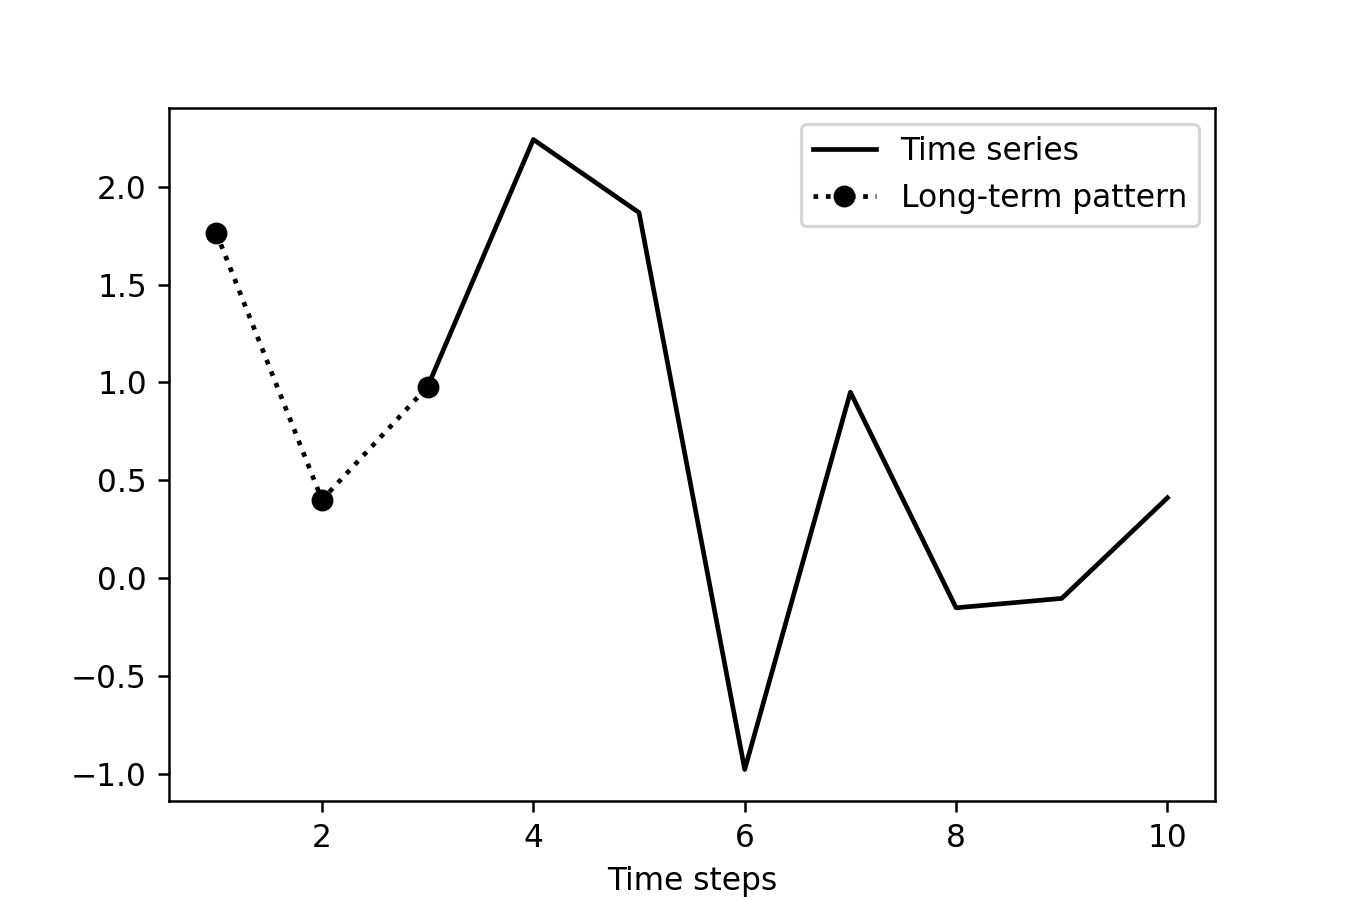

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(range(3, T + 1), arr[2:], c='k', label='Time series')
plt.plot(range(1, 4), arr[:3], c='k', ls=':', marker='o', label='Long-term pattern')
plt.xlabel('Time steps')
plt.legend()
# plt.savefig('out/plots/lt_pattern.png', dpi=600, transparent=True)
plt.show()

<IPython.core.display.Javascript object>


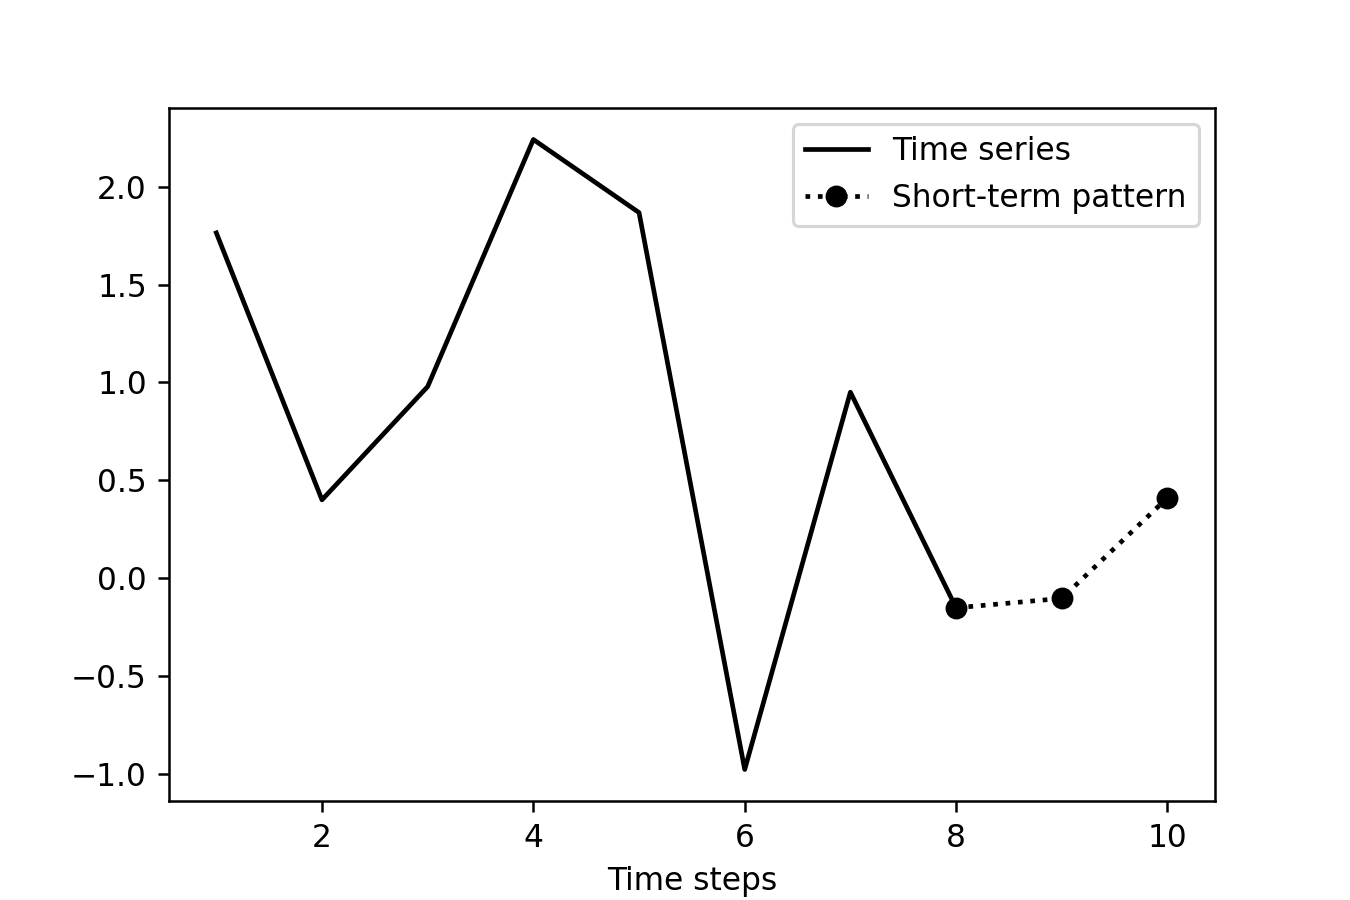

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, T - 1), arr[:-2], c='k', label='Time series')
plt.plot(range(T - 2, T + 1), arr[T - 3:], c='k', ls=':', marker='o', label='Short-term pattern')
plt.xlabel('Time steps')
plt.legend()
# plt.savefig('out/plots/st_pattern.png', dpi=600, transparent=True)
plt.show()

In [9]:
def encode_to_bits(x) -> int:
    return int(np.sign(x)) if x > 0 else int(0)

In [10]:
def get_label(x: np.ndarray, i1: int, i2: int, i3: int) -> int:
    x1: int = encode_to_bits(x[i1]) 
    x2: int = encode_to_bits(x[i2]) 
    x3: int = encode_to_bits(x[i3])
    xor: int = x1 ^ x2 ^ x3
    return 0 if xor == 1 else 1

In [11]:
def generate_distance(T: int = 10, short: bool = True) -> tuple:
    arr = np.array([-4, 10, 5])
    assert get_label(arr, 0, 1, 2) == 1, "There is a problem with 'get_label' function."
    
    x_store: list = []
    y_store: list = []
    
    for t in range(5000):
        x: np.ndarray = np.random.randn(T)
        x_store.append(x)
        if short:
            y = get_label(x, -1, -2, -3)
        else:
            y = get_label(x, 0, 1, 2)
        y_store.append(y)
    
    n: int = len(x_store)
    return np.array(x_store), np.array(y_store), n

In [12]:
X, Y, N = generate_distance(T, short=True)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (5000, 10), Y.shape: (5000,)


### XOR plotting

<IPython.core.display.Javascript object>


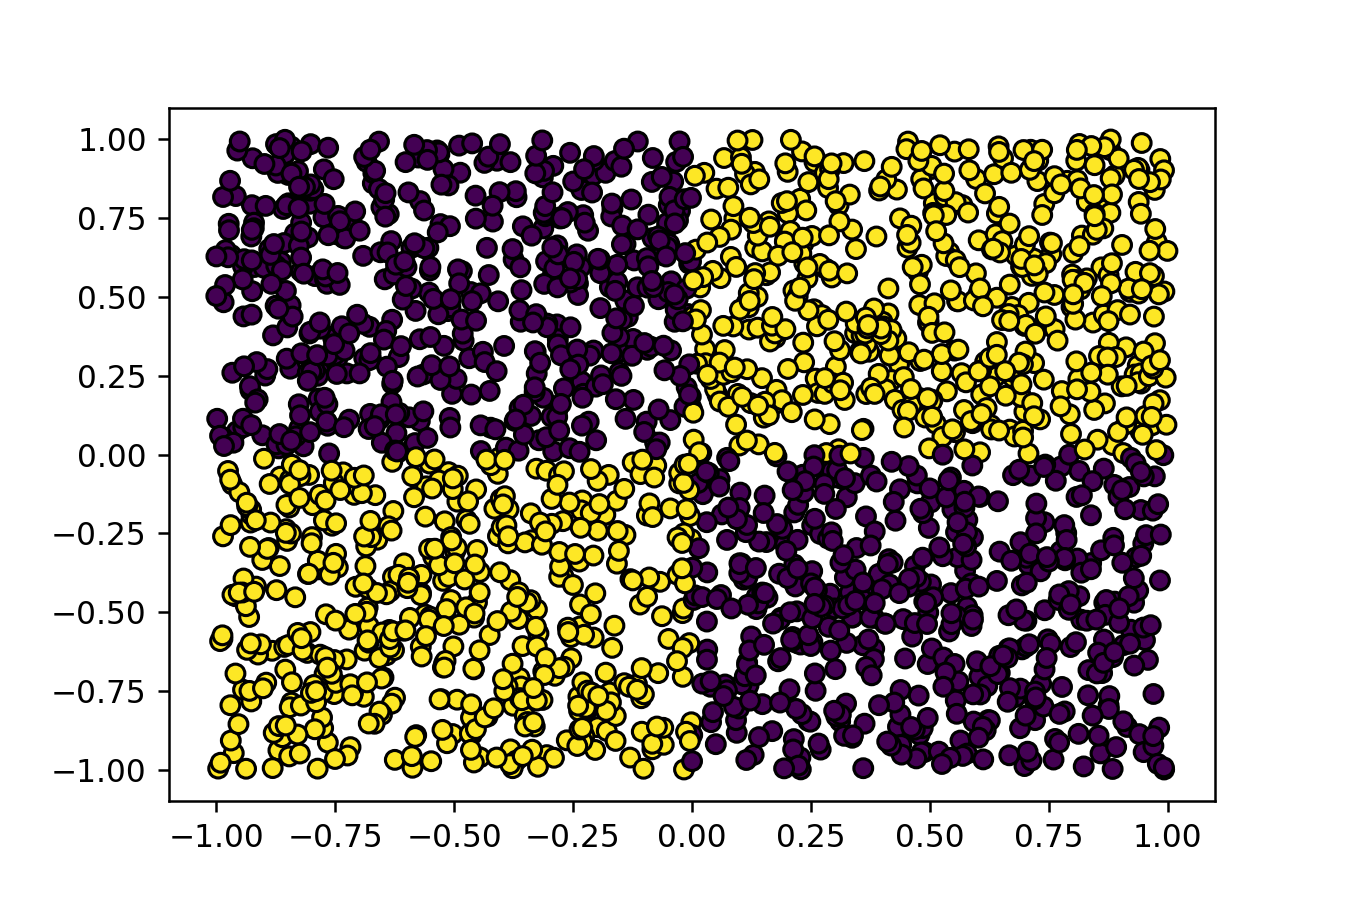

In [13]:
N_: int = 2000
X2d = np.random.random((N_, 2)) * 2 - 1
Y2d = [0 if (encode_to_bits(x[0]) ^ encode_to_bits(x[1])) == 1 else 1 for x in X2d]

plt.figure(figsize=(6, 4))
plt.scatter(X2d[:, 0], X2d[:, 1], c=Y2d, edgecolor='k')
# plt.savefig('out/plots/xor2d.png', dpi=600, transparent=True)
plt.show()

<IPython.core.display.Javascript object>


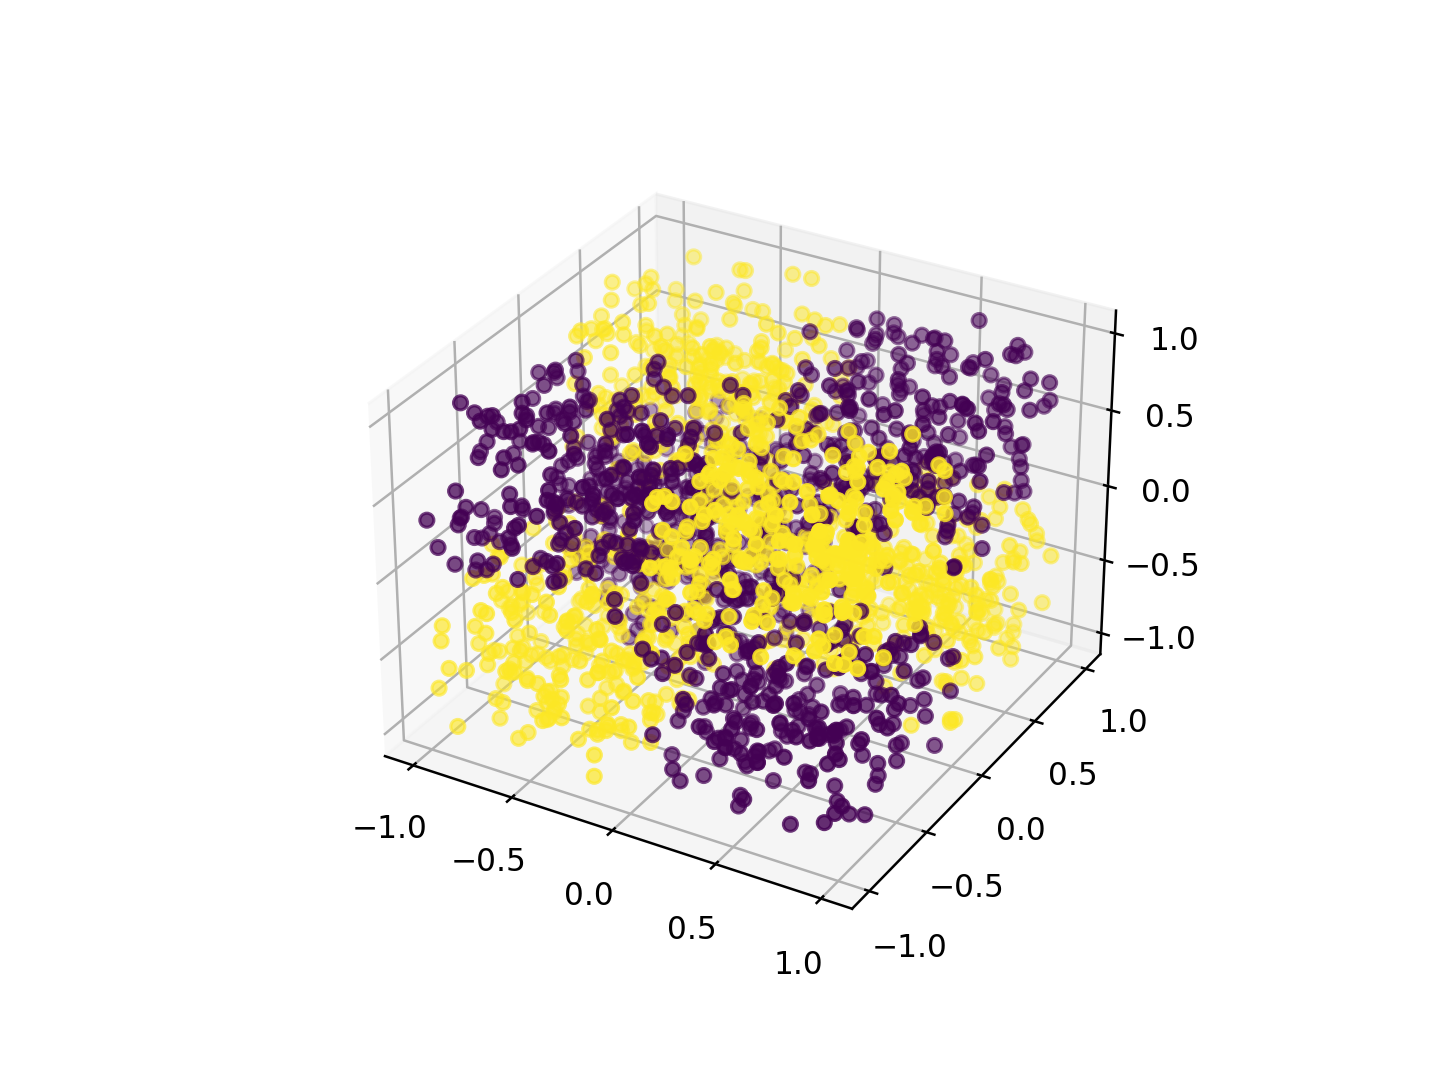

In [14]:
X_ = np.random.random((N_, 3)) * 2 - 1
Y_ = [get_label(x, 0, 1, 2) for x in X_]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_[:, 0], X_[:, 1], X_[:, 2], c=Y_)
# plt.savefig('out/plots/xor3d.png', dpi=600, transparent=True)
plt.show()

## Section 1. Short-distance: Linear model versus Simple RNN

Test different configurations of RNNs and see how they perform.

### Linear model

We know ex-ante that this model is going to fail because the decision boundary in non-linear.

<IPython.core.display.Javascript object>


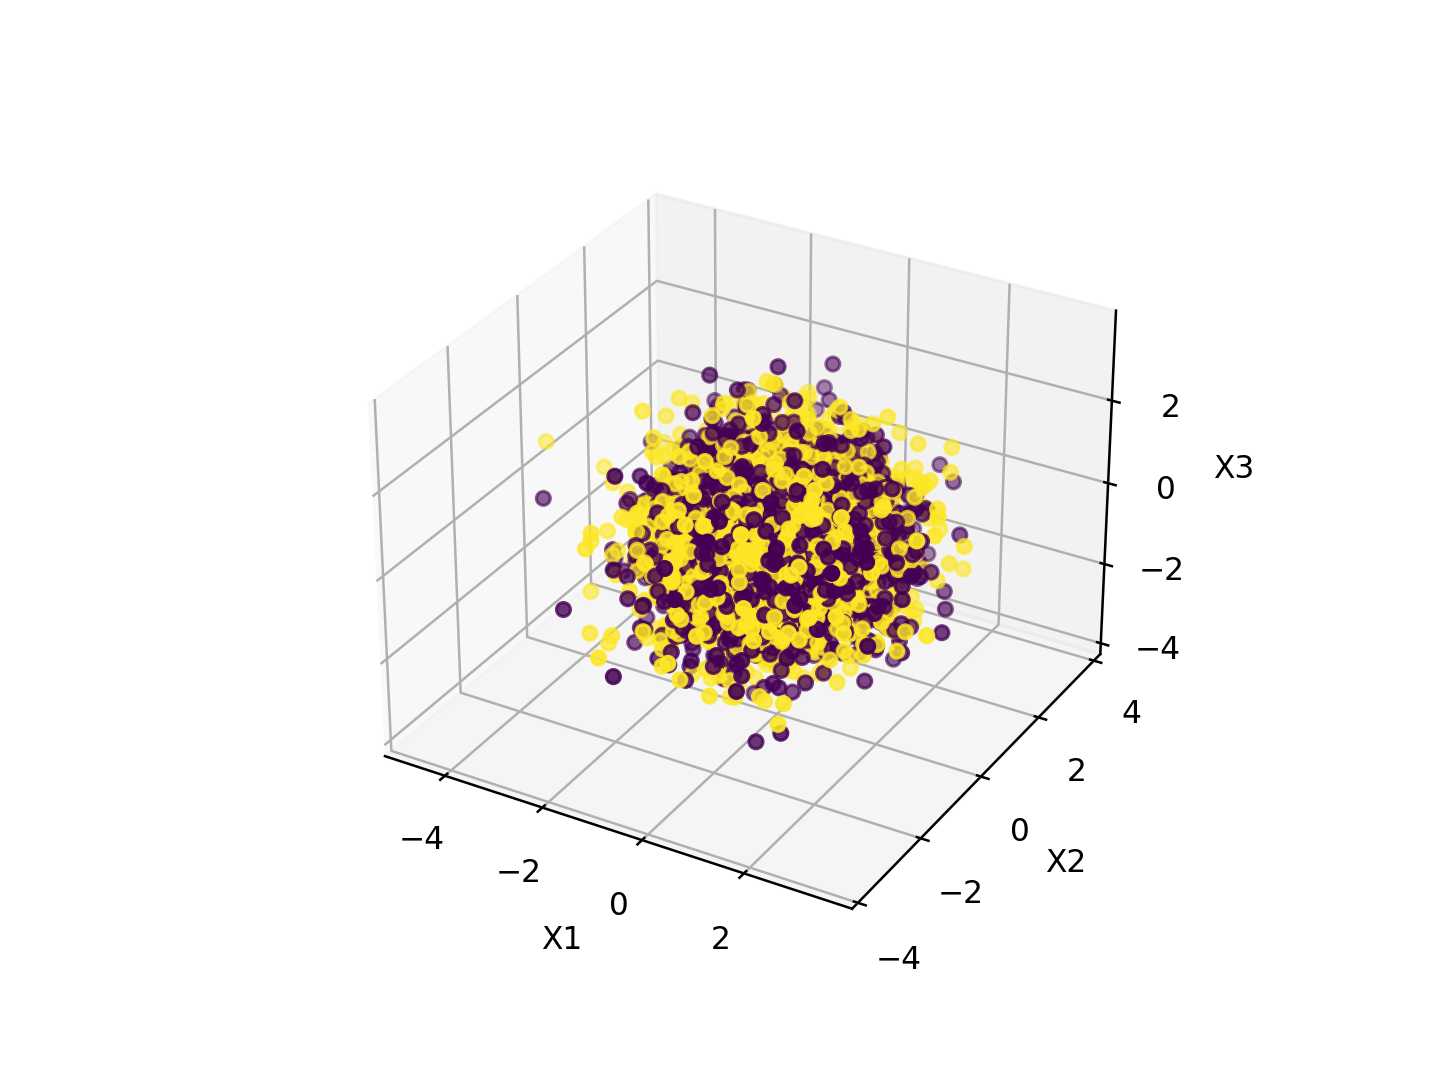

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

plt.show()

In [16]:
inputs = Input(shape=(T,))
x = Dense(1, activation='sigmoid')(inputs)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [17]:
results['short-distance-10']['linreg'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

So, as expected, this model fails because it only achieves approx. 50% accuracy. Furthermore, although the loss goes down, it converges to a high value (around 0.6).

In [18]:
results['short-distance-10']['linreg'].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
predictions = model.predict(X)

<IPython.core.display.Javascript object>


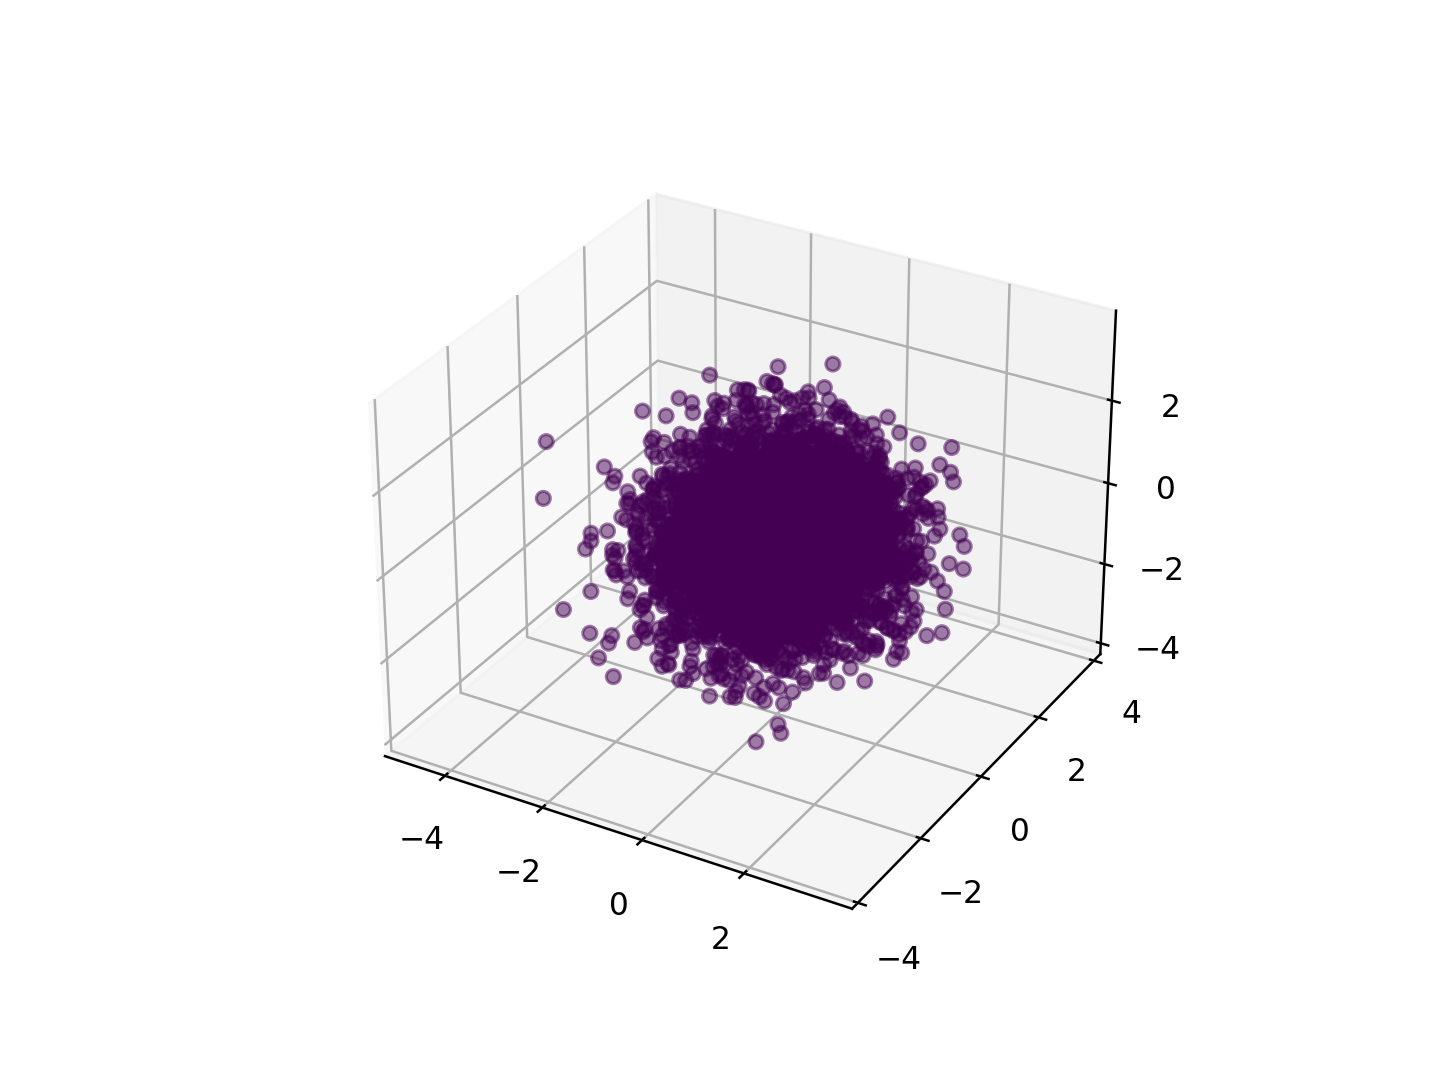

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=[1 if 1/(1 + np.exp(-x)) > 0.5 else 0 for x in predictions], alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


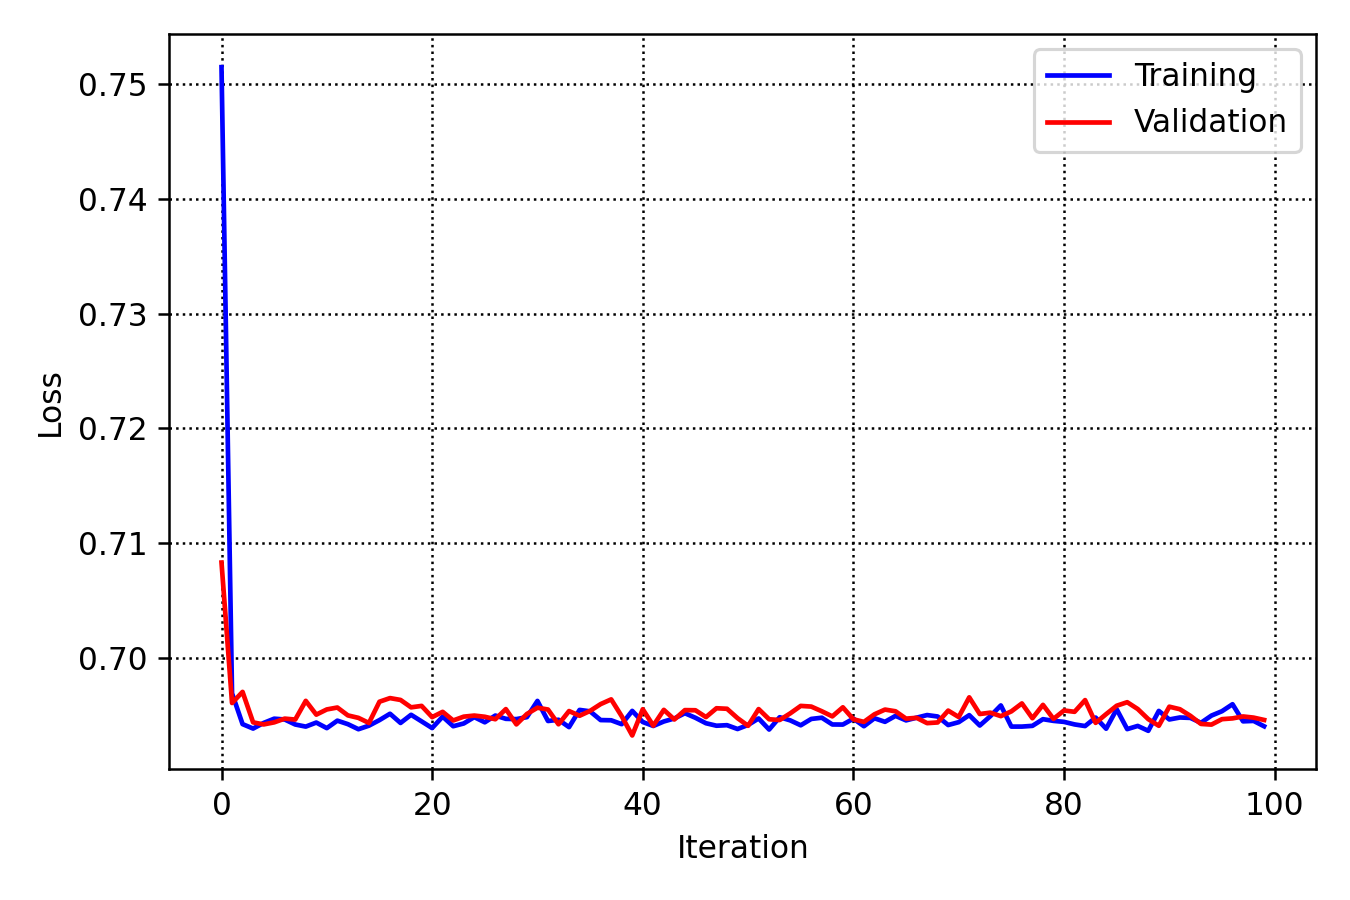

In [21]:
utils.plot_loss(results['short-distance-10']['linreg'].history['loss'], 
                results['short-distance-10']['linreg'].history['val_loss'],
                save=False, imgname='loss_st10_xor_linreg')

<IPython.core.display.Javascript object>


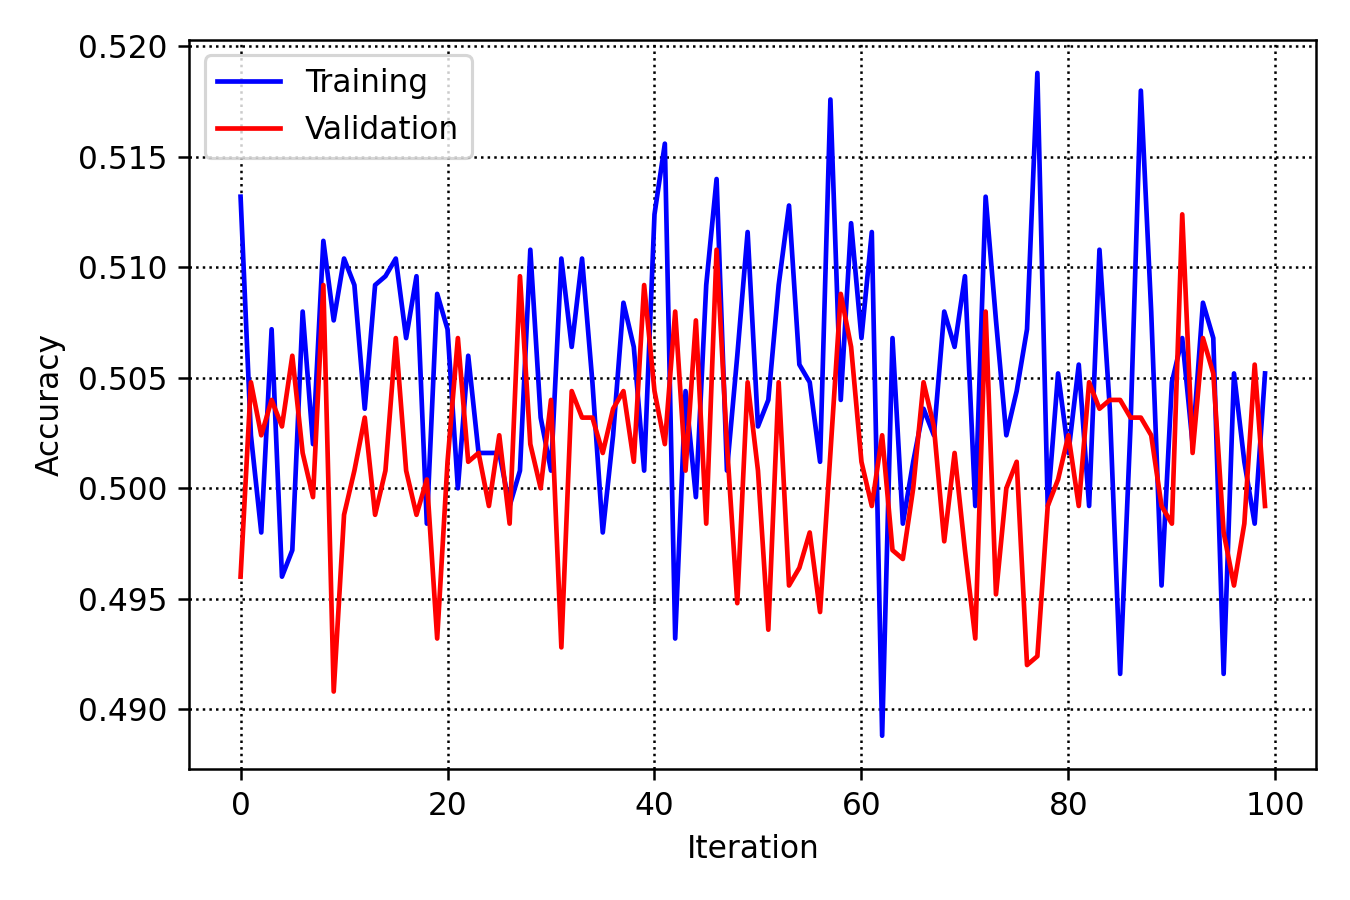

In [22]:
utils.plot_accuracy(results['short-distance-10']['linreg'].history['accuracy'], 
                    results['short-distance-10']['linreg'].history['val_accuracy'],
                    save=False, imgname='accuracy_xor_ar')

## Simple RNN

In [23]:
# class MyModel:
#     _models: dict = {'SimpleRNN': SimpleRNN,
#                      'LSTM': LSTM,
#                      'GRU': GRU,
#                      'AR': SimpleRNN}
    
#     def __init__(self, 
#                  inputs: np.ndarray,
#                  model: str = 'SimpleRNN', 
#                  units: int = 5,
#                  activation: str = 'tanh',
#                  out_activation: str = 'sigmoid', 
#                  loss: str = 'binary_crossentropy',
#                  optimizer = 'rmsprop',
#                  lookback_window_size: int = 10,
#                  num_features: int = 1):
    
#         self.X: np.ndarray = inputs if model == 'SimpleRNN' else np.expand_dims(inputs, -1)
#         self.model_name: str = model
#         self.units: int = units
#         self.activation: str = activation
#         self.out_activation: str = out_activation
#         self.loss: str = loss
#         self.optimizer = optimizer
#         self.T: int = lookback_window_size
#         self.D: int = num_features
#         self.model = self.build_model()
        
#     def build_model(self):
#         i = Input(shape=(self.T, self.D))
#         if self.model_name == 'AR':
#             x = MyModel._models[self.model_name](self.units, activation=None)(i)
#         else:
#             x = MyModel._models[self.model_name](self.units)(i)
#         x = Dense(1, activation=self.out_activation)(x)
#         m = Model(i, x)
#         m.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])        

In [24]:
# rnn = MyModel(X)

In [25]:
# models_config: dict = {
#     'simple_rnn': {}
# }

In [26]:
X3d = np.expand_dims(X, -1)
inputs = Input(shape=(T, D))
x = SimpleRNN(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])     

In [27]:
results['short-distance-10']['simple-rnn'] = model.fit(X3d, Y, epochs=100, validation_split=0.5, verbose=0)

In [28]:
predictions = model.predict(X3d)

<IPython.core.display.Javascript object>


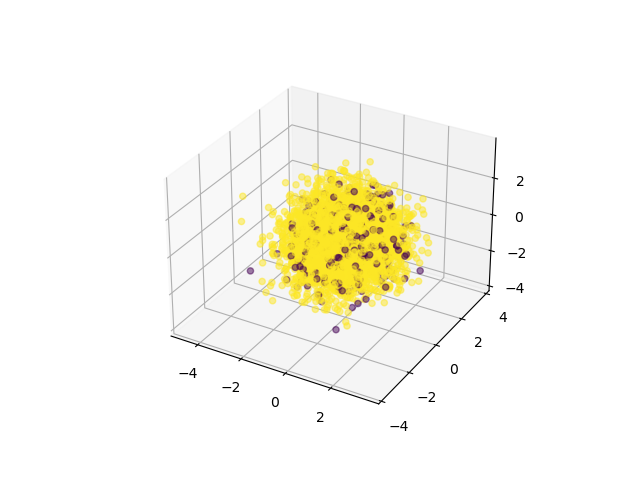

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3d[:, 0, 0], X3d[:, 1, 0], X3d[:, 2, 0], c=[1 if 1/(1 + np.exp(-x)) > 0.5 else 0 for x in predictions], alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


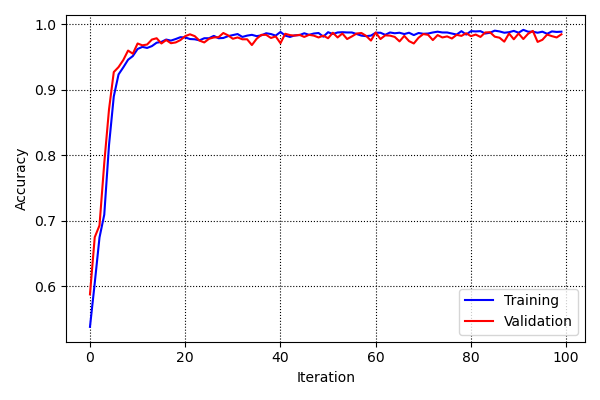

In [30]:
utils.plot_accuracy(results['short-distance-10']['simple-rnn'].history['accuracy'],
                    results['short-distance-10']['simple-rnn'].history['val_accuracy'],
                    save=False, imgname='accuracy_st10_xor_rnn')

<IPython.core.display.Javascript object>


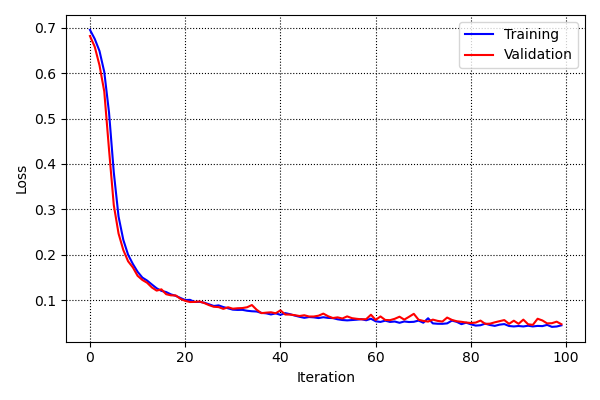

In [31]:
utils.plot_loss(results['short-distance-10']['simple-rnn'].history['loss'], 
                results['short-distance-10']['simple-rnn'].history['val_loss'],
                save=False, imgname='loss_st10_xor_rnn')

The Simple RNN has low loss and a high accuracy curve. They look good, as expected. Meaning that a Simple RNN can solve this problem. Since the part if the time series that affects the classification result is a the end of the sequence, it does not require any long term memory. Thus, the vanishing gradient problem is not an issue here.

## Section 2. Long-term dependency with 10 periods

The pattern that affects the classification result is now far back in the time series.

### Simple RNN

In [32]:
X, Y, N = generate_distance(T, short=False)

In [33]:
X3d = np.expand_dims(X, -1)
inputs = Input(shape=(T, D))
x = SimpleRNN(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [34]:
results['long-distance-10']['simple-rnn'] = model.fit(X3d, Y, epochs=100, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


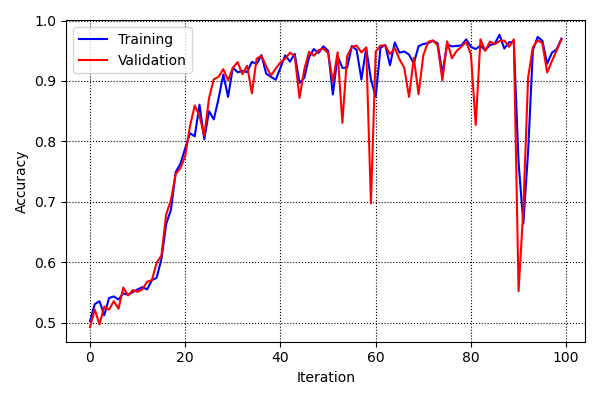

In [35]:
utils.plot_accuracy(results['long-distance-10']['simple-rnn'].history['accuracy'], 
                    results['long-distance-10']['simple-rnn'].history['val_accuracy'],
                    save=False, imgname='accuracy_lt10_xor_rnn')

<IPython.core.display.Javascript object>


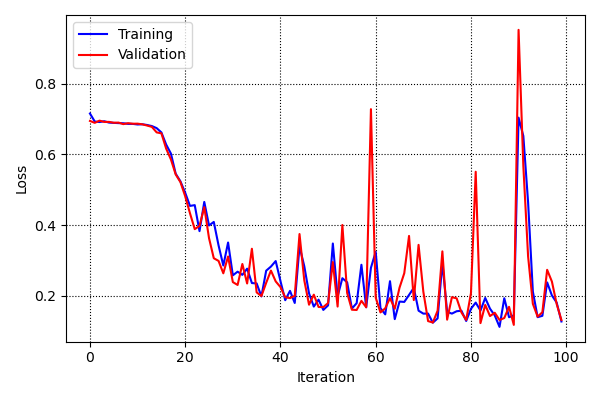

In [36]:
utils.plot_loss(results['long-distance-10']['simple-rnn'].history['loss'],
                results['long-distance-10']['simple-rnn'].history['val_loss'],
                save=False, imgname='loss_lt10_xor_rnn')

The RNN has now a harder time learning the (long-term) pattern. This is why the loss is so high and the accuracy low. These do not look very good at all.

### LSTM

In [37]:
X3d = np.expand_dims(X, -1)
inputs = Input(shape=(T, D))
x = LSTM(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [38]:
results['long-distance-10']['simple-lstm'] = model.fit(X3d, Y, epochs=100, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


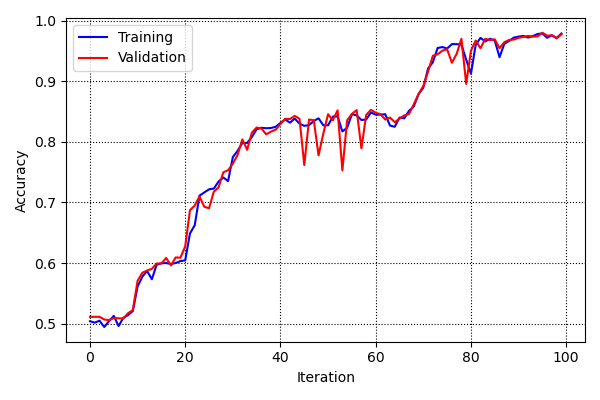

In [39]:
utils.plot_accuracy(results['long-distance-10']['simple-lstm'].history['accuracy'],
                    results['long-distance-10']['simple-lstm'].history['val_accuracy'], 
                    save=False, imgname='accuracy_lt10_xor_lstm')

<IPython.core.display.Javascript object>


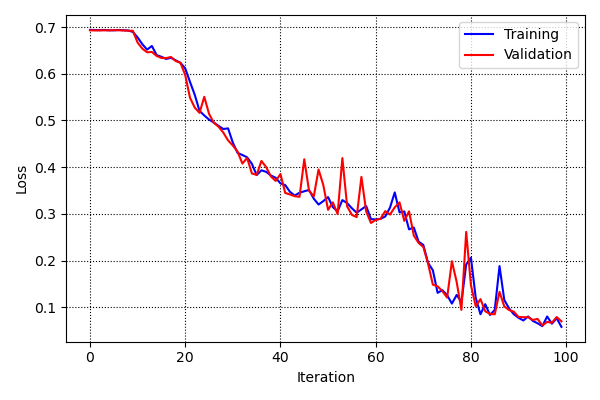

In [40]:
utils.plot_loss(results['long-distance-10']['simple-lstm'].history['loss'],
                results['long-distance-10']['simple-lstm'].history['val_loss'], 
                save=False, imgname='loss_lt10_xor_lstm')

Now, the accuracy is very high, and the loss is very low.

We can see that the LSTM achieves a much better accuracy and loss per iteration. This makes sense because LSTM was built to capture long distance patters.

## Section 3. Long-term dependency with 20 periods


### Simple RNN

In [41]:
T: int = 20

In [42]:
X, Y, N = generate_distance(T, short=False)

In [43]:
X3d = np.expand_dims(X, -1)
inputs = Input(shape=(T, D))
x = SimpleRNN(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [44]:
results['long-distance-20']['simple-rnn'] = model.fit(X3d, Y, epochs=200, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


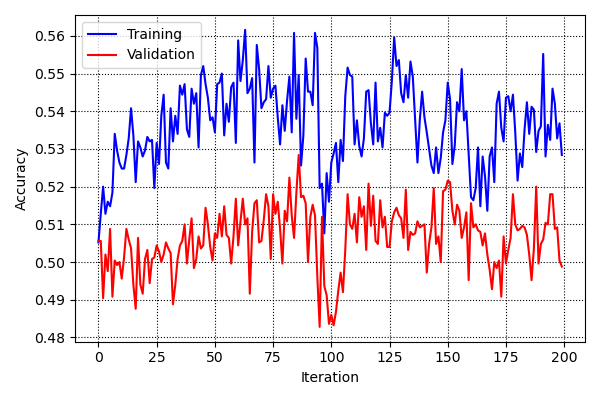

In [45]:
utils.plot_accuracy(results['long-distance-20']['simple-rnn'].history['accuracy'],
                    results['long-distance-20']['simple-rnn'].history['val_accuracy'],
                    save=False, imgname='accuracy_lt20_xor_rnn')

<IPython.core.display.Javascript object>


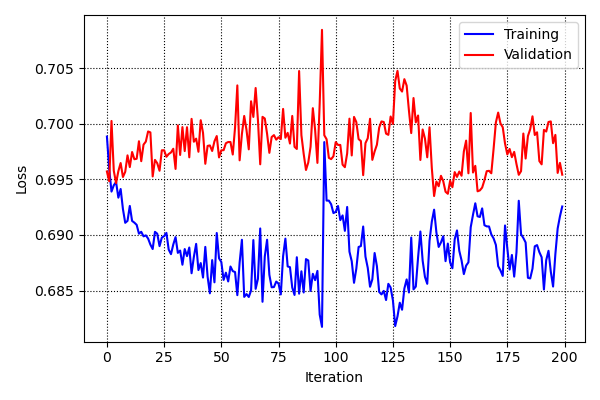

In [46]:
utils.plot_loss(results['long-distance-20']['simple-rnn'].history['loss'],
                results['long-distance-20']['simple-rnn'].history['val_loss'],
                save=False, imgname='loss_lt20_xor_rnn')

### LSTM

In [47]:
X3d = np.expand_dims(X, -1)
inputs = Input(shape=(T, D))
x = LSTM(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [48]:
results['long-distance-20']['lstm'] = model.fit(X3d, Y, epochs=200, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


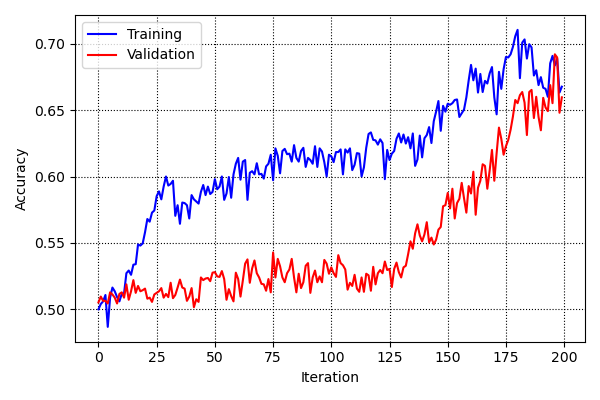

In [49]:
utils.plot_accuracy(results['long-distance-20']['lstm'].history['accuracy'],
                    results['long-distance-20']['lstm'].history['val_accuracy'], 
                    save=False, imgname='accuracy_lt20_xor_lstm')

<IPython.core.display.Javascript object>


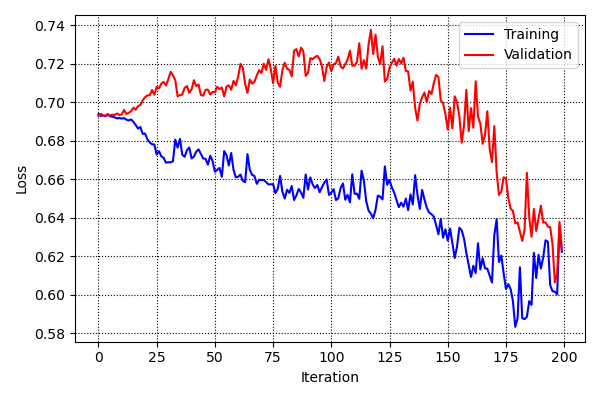

In [50]:
utils.plot_loss(results['long-distance-20']['lstm'].history['loss'],
                results['long-distance-20']['lstm'].history['val_loss'],
                save=False, imgname='loss_lt20_xor_lstm')

### GRU

In [51]:
X3d = np.expand_dims(np.copy(X), -1)
inputs = Input(shape=(T, D))
x = GRU(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [52]:
results['long-distance-20']['gru'] = model.fit(X3d, Y, epochs=400, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


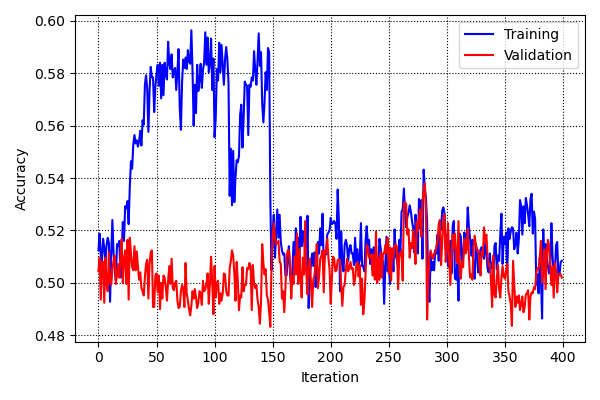

In [53]:
utils.plot_accuracy(results['long-distance-20']['gru'].history['accuracy'],
                    results['long-distance-20']['gru'].history['val_accuracy'], 
                    save=False, imgname='accuracy_lt20_xor_gru')

C:\Users\YBant\Documents\projects\deep_learning\tsa\utils.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6, 4))


<IPython.core.display.Javascript object>


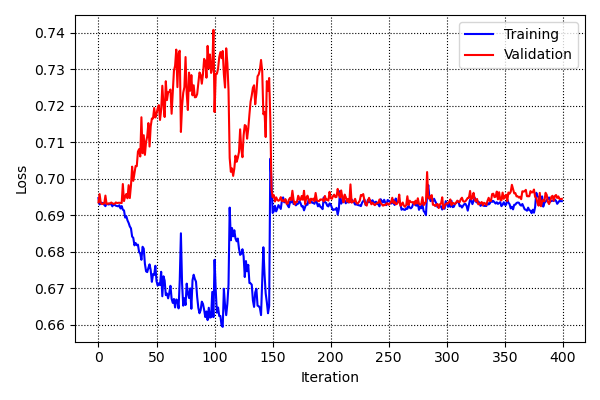

In [54]:
utils.plot_loss(results['long-distance-20']['gru'].history['loss'],
                results['long-distance-20']['gru'].history['val_loss'],
                save=False, imgname='loss_lt20_xor_gru')

## Section 4. Long-distance with 30 periods


### LSTM

In [55]:
T = 30

In [56]:
X, Y, N = generate_distance(T, short=False)

In [57]:
X3d = np.expand_dims(X, -1)
inputs = Input(shape=(T, D))
x = LSTM(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [58]:
results['long-distance-30']['lstm'] = model.fit(X3d, Y, epochs=400, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


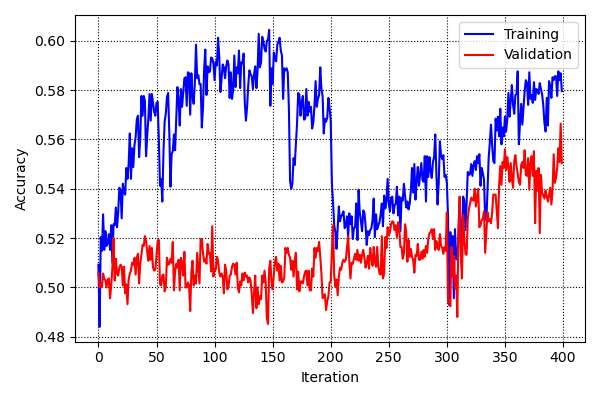

In [59]:
utils.plot_accuracy(results['long-distance-30']['lstm'].history['accuracy'],
                    results['long-distance-30']['lstm'].history['val_accuracy'], 
                    save=False, imgname='accuracy_lt30_xor_lstm')

<IPython.core.display.Javascript object>


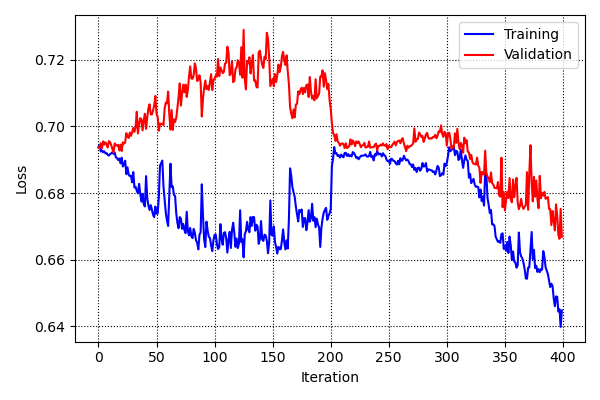

In [60]:
utils.plot_loss(results['long-distance-30']['lstm'].history['loss'],
                results['long-distance-30']['lstm'].history['val_loss'],
                save=False, imgname='loss_lt30_xor_lstm')